In [1]:
import numpy as np
from numpy.random import default_rng
from scipy import signal
from lfp_prediction.config import params

RNG = default_rng(seed=67)

RAW_LFP = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/raw_data/LFP_elec_combine.txt'

In [2]:
def get_whitenoise(time_s=300000, channels=1):
    osc_band = np.array([0.08, 0.14])
    b, a = signal.butter(4, osc_band, btype='bandpass', output='ba')

    with open(RAW_LFP) as f:
        lfp_in = f.read().splitlines()
    lfp_in = np.array([float(x) for x in lfp_in]).reshape((-1, 1))

    noise = RNG.normal(0, np.std(lfp_in), (time_s, channels))

    noise_filt = signal.lfilter(b, a, noise, axis=0)

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(noise_filt[h:h + params.LOOK_AHEAD, 0].reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

# data, labels = get_whitenoise()
# print(data.shape)
# print(labels.shape)

In [3]:
def get_whitenoise_dynamic_filt(time_s=300000, channels=1):
    osc_band = np.array([0.08, 0.14])
    b, a = signal.butter(4, osc_band, btype='bandpass', output='ba')

    with open(RAW_LFP) as f:
        lfp_in = f.read().splitlines()
    lfp_in = np.array([float(x) for x in lfp_in]).reshape((-1, 1))

    noise = RNG.normal(0, np.std(lfp_in), (time_s, channels))

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(signal.lfilter(b, a, noise[h:h+params.LOOK_AHEAD,0], axis=0).reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

# data, labels = get_whitenoise_dynamic_filt()
# print(data.shape)
# print(labels.shape)

In [4]:
def get_whitenoise_raw(time_s=300000, channels=1):
    with open(RAW_LFP) as f:
        lfp_in = f.read().splitlines()
    lfp_in = np.array([float(x) for x in lfp_in]).reshape((-1, 1))

    noise = RNG.normal(0, np.std(lfp_in), (time_s, channels))

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(noise[h:h+params.LOOK_AHEAD,0].reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

# data, labels = get_whitenoise_raw()
# print(data.shape)
# print(labels.shape)

In [5]:
from scipy import fft, stats
from scipy.io import loadmat

def generate_pinknoise():
    datafile = "/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat"
    data = loadmat(datafile)

    fs = data['fs'][0,0]
    scale = data['scale'][0,0]
    LFP_seg = [scale*x.ravel() for x in data['LFP_seg'].ravel()]

    LFP_cat = np.concatenate(LFP_seg)

    nfft = 2**7 # 128 samples
    f, Pxx = signal.welch(LFP_cat, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')
    f = f.ravel()

    f_cutoff = max(np.argmax(Pxx),1)
    Pmax = Pxx[f_cutoff]
    idx = np.arange(f_cutoff,f.size)
    result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
    b = result.intercept
    a = -result.slope

    f_cutoff = np.exp((b-np.log(Pmax))/a)

    def pink_noise(f, alpha=1., fmin=0):
        """
        f: normalized frequencies
        alpha: exponent of pink noise
        fmin: Low-frequency cutoff
        """
        S = 1/np.where(f == 0, float('inf'), f**(alpha/2))
        if fmin>0:
            S[(f<fmin) & (f!=0)] = fmin**(-alpha/2)
        return S

    def noise_gen(N, psd = lambda f: 1):
        f = fft.rfftfreq(N)
        Scale = psd(f)
        w = Scale[1:].copy()
        w[-1] *= (1 + (N % 2)) / 2. # correct f = +-0.5
        sigma = 2 * np.sqrt(np.sum(w**2)) / N
        sr = Scale * np.random.randn(len(f))
        si = Scale * np.random.randn(len(f))
        if not (N % 2): si[-1] = 0 # If the signal length is even, frequencies +/- 0.5 are equal, the coefficient must be real.
        si[0] = 0 # Regardless of signal length, the DC component must be real
        s  = sr + 1J * si
        X = fft.irfft(s) / sigma
        return X

    N = 2**((LFP_cat.size-1).bit_length()-1) # choose power of 2 samples
    noise_psd = lambda f: pink_noise(f, alpha=a, fmin=f_cutoff/fs) # function for calculating noise psd
    x_noise = (np.std(LFP_cat) * noise_gen(N, psd = noise_psd)).reshape((-1, 1))
    # print(x_noise.shape)
    return x_noise

def get_pinknoise(pinknoise):
    osc_band = np.array([30, 55])
    b, a = signal.butter(4, osc_band, btype='bandpass', output='ba', fs=1000)

    noise = pinknoise

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(signal.lfilter(b, a, noise[h:h+params.LOOK_AHEAD,0], axis=0).reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

fullpink = generate_pinknoise()
data, labels = get_pinknoise(fullpink[:30000, :])
print(data.shape)
print(labels.shape)

(27852, 1, 2048)
(27852, 1, 100)


In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_data = DataLoader(TensorDataset(torch.Tensor(data[:20000, :, :]), torch.Tensor(labels[:20000, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[20000:, :, :]), torch.Tensor(labels[20000:, :, :])), batch_size=batch_size, shuffle=False)

In [8]:
import torch.nn as nn
from tqdm.notebook import tqdm

def train_model(model,training_loader,validation_loader,epochs,device):
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_func = nn.MSELoss()
    decay_rate = .99995 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    validation_loss, training_loss = [], []

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                if params.RECURRENT_NET:
                    x = torch.transpose(x, 2, 1)
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
                training_loss.append(train_loss)
            else:
                val_loss = running_loss
                validation_loss.append(val_loss)

        # shows total loss
        if epoch%5 == 0:
            tqdm.write('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))
    return training_loss, validation_loss

In [9]:
import copy
from lfp_prediction.models.LFPNet import FCN

epochs = 50

model = FCN(in_size=2048, h_size=500, out_size=100)
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = train_model(model, train_data, valid_data, epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

[1,   246] train loss: 544649.516785 val loss: 221163.731598
[6,   246] train loss: 479544.158600 val loss: 224793.984344
[11,   246] train loss: 468368.992371 val loss: 232029.034485
[16,   246] train loss: 463886.156372 val loss: 231348.433228
[21,   246] train loss: 460656.956940 val loss: 224592.416534
[26,   246] train loss: 458715.675903 val loss: 232115.213638
[31,   246] train loss: 458714.225037 val loss: 229215.881790
[36,   246] train loss: 456092.520630 val loss: 238795.579178
[41,   246] train loss: 456226.880402 val loss: 237430.384079
[46,   246] train loss: 456169.734070 val loss: 227861.502640


In [10]:
model.eval()
x = torch.Tensor(data[20000,:,:]).to(device)
output = model(x)
out = output.detach().cpu().numpy()

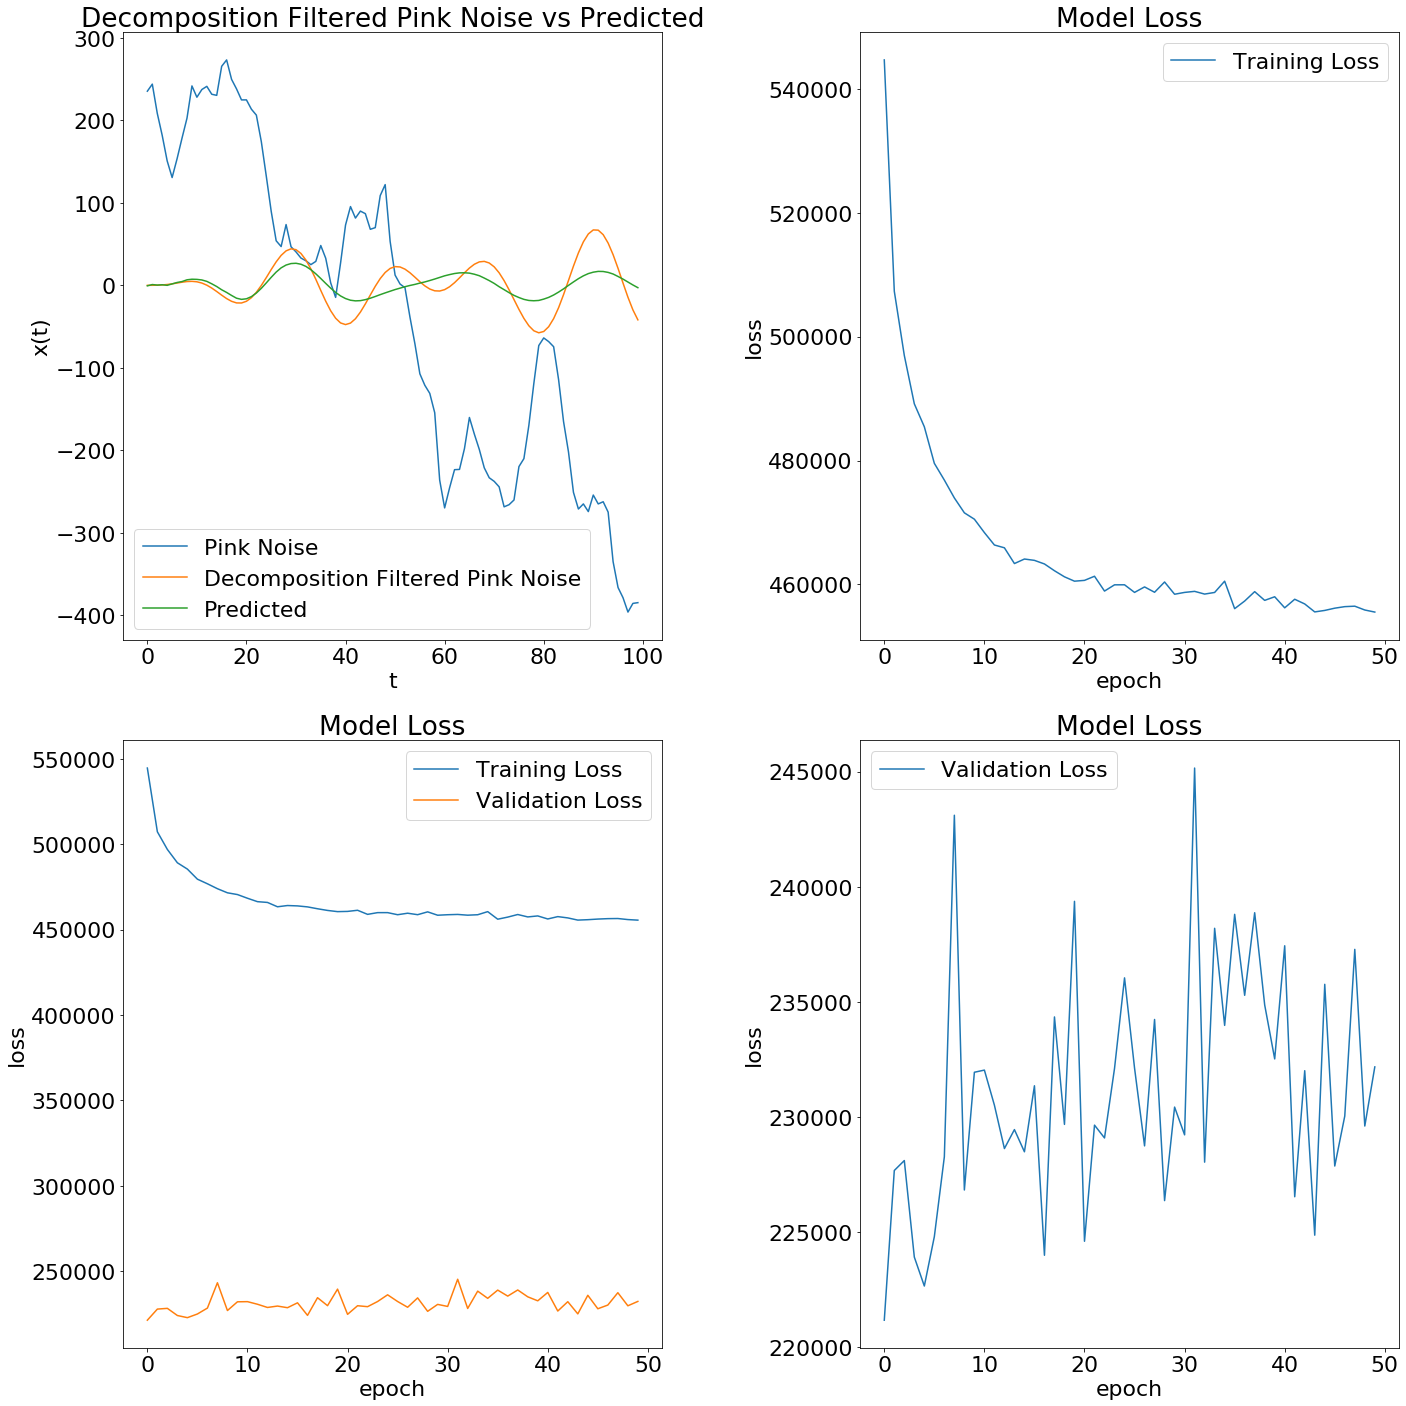

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 22

fig, axs = plt.subplots(2,2)

t = np.arange(0, 100, 1)

time_var = 100

axs[0,0].plot(t, data[20001,0,:100], label='Pink Noise')
axs[0,0].plot(t, labels[20000,0,:], label='Decomposition Filtered Pink Noise')
axs[0,0].plot(t, out[0,:], label='Predicted')

axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('x(t)')
axs[0,0].set_title('Decomposition Filtered Pink Noise vs Predicted')
axs[0,0].legend(loc='best')

axs[1,0].plot(np.arange(epochs), np.array(t_loss), label='Training Loss')
axs[1,0].plot(np.arange(epochs), np.array(v_loss), label='Validation Loss')

axs[1,0].set_xlabel('epoch')
axs[1,0].set_ylabel('loss')
axs[1,0].set_title('Model Loss')
axs[1,0].legend(loc='best')

axs[0,1].plot(np.arange(epochs), np.array(t_loss), label='Training Loss')

axs[0,1].set_xlabel('epoch')
axs[0,1].set_ylabel('loss')
axs[0,1].set_title('Model Loss')
axs[0,1].legend(loc='best')

axs[1,1].plot(np.arange(epochs), np.array(v_loss), label='Validation Loss')

axs[1,1].set_xlabel('epoch')
axs[1,1].set_ylabel('loss')
axs[1,1].set_title('Model Loss')
axs[1,1].legend(loc='best')

fig.tight_layout()
plt.show()